This is not original at all!!
Data Munging: https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series (Please Upvote!)
LSTM: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru (Please Upvote!)

In [15]:
# BASIC IDEA OF THE KERNEL

# The data consists of a one dimensional time series x with 600 Mio data points. 
# At test time, we will see a time series of length 150'000 to predict the next earthquake.
# The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
# features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
# time steps. 

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm
# Define model
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, Dropout, TimeDistributed, LSTM, CuDNNLSTM
from keras.optimizers import adam, RMSprop
from keras.callbacks import ModelCheckpoint
# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
float_data = pd.read_csv("../input/train/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

# Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
# Can easily be extended. Expects a two dimensional array.
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
                  #np.sqrt(np.abs(z)).mean(axis=1)
                 ]

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:]),
                 extract_features(temp[:, -step_length // 300:])]

# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
    
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)

Our RNN is based on 16 features


In [16]:
n_features

16

In [17]:
%%time
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=(None,n_features)))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(CuDNNLSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(CuDNNLSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(CuDNNLSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN


model.summary()

# Compile and fit model
model.compile(optimizer='rmsprop', loss='mae')



history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=40,
                              verbose=2,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200
                             )





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, None, 50)          13600     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 50)                20400     
__________

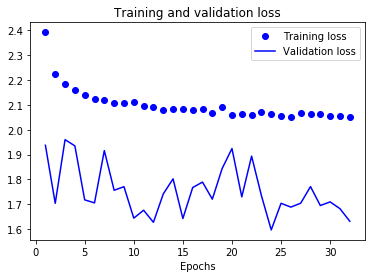

In [4]:
# Visualize accuracies
import matplotlib.pyplot as plt
%matplotlib inline
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None
perf_plot(history) # Extra Layer

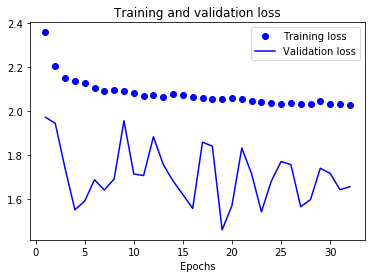

In [10]:
# Visualize accuracies
import matplotlib.pyplot as plt
%matplotlib inline
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None
perf_plot(history) # Extra Layer

In [5]:
# Load submission file
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})
x = None
# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values[:]
    #print(x.shape)
    submission.time_to_failure[i] = (model.predict(np.expand_dims(create_X(x), 0)))

# Save
submission.to_csv('submission-ltsm.csv')

100%|██████████| 2624/2624 [01:21<00:00, 32.38it/s]


In [6]:
submission.head(10)

,time_to_failure
seg_id,
seg_00030f,2.956320
seg_0012b5,5.255170
seg_00184e,5.296908
seg_003339,8.218883
seg_0042cc,5.906256
seg_004314,1.614901
seg_004cd2,6.057047
seg_004ee5,5.011396
seg_004f1f,5.068751


In [ ]:
original features 
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]
Epoch 1/32
 - 66s - loss: 2.3928 - val_loss: 1.9370
Epoch 2/32
 - 63s - loss: 2.2244 - val_loss: 1.7033
Epoch 3/32
 - 62s - loss: 2.1842 - val_loss: 1.9598
Epoch 4/32
 - 62s - loss: 2.1599 - val_loss: 1.9348
Epoch 5/32
 - 64s - loss: 2.1407 - val_loss: 1.7172
Epoch 6/32
 - 64s - loss: 2.1230 - val_loss: 1.7050
Epoch 7/32
 - 63s - loss: 2.1201 - val_loss: 1.9158
Epoch 8/32
 - 62s - loss: 2.1078 - val_loss: 1.7558
Epoch 9/32
 - 63s - loss: 2.1064 - val_loss: 1.7702
Epoch 10/32
 - 63s - loss: 2.1122 - val_loss: 1.6435
Epoch 11/32
 - 63s - loss: 2.0944 - val_loss: 1.6754
Epoch 12/32
 - 63s - loss: 2.0927 - val_loss: 1.6267
Epoch 13/32
 - 63s - loss: 2.0813 - val_loss: 1.7408
Epoch 14/32
 - 63s - loss: 2.0837 - val_loss: 1.8019
Epoch 15/32
 - 64s - loss: 2.0842 - val_loss: 1.6420
Epoch 16/32
 - 63s - loss: 2.0797 - val_loss: 1.7668
Epoch 17/32
 - 64s - loss: 2.0844 - val_loss: 1.7888
Epoch 18/32
 - 64s - loss: 2.0684 - val_loss: 1.7200
Epoch 19/32
 - 65s - loss: 2.0914 - val_loss: 1.8434
Epoch 20/32
 - 64s - loss: 2.0600 - val_loss: 1.9241
Epoch 21/32
 - 64s - loss: 2.0642 - val_loss: 1.7292
Epoch 22/32
 - 63s - loss: 2.0589 - val_loss: 1.8935
Epoch 23/32
 - 61s - loss: 2.0733 - val_loss: 1.7342
Epoch 24/32
 - 63s - loss: 2.0645 - val_loss: 1.5960
Epoch 25/32
 - 63s - loss: 2.0541 - val_loss: 1.7033
Epoch 26/32
 - 64s - loss: 2.0526 - val_loss: 1.6880
Epoch 27/32
 - 64s - loss: 2.0662 - val_loss: 1.7038
Epoch 28/32
 - 63s - loss: 2.0614 - val_loss: 1.7706
Epoch 29/32
 - 63s - loss: 2.0617 - val_loss: 1.6943
Epoch 30/32
 - 61s - loss: 2.0569 - val_loss: 1.7090
Epoch 31/32
 - 62s - loss: 2.0566 - val_loss: 1.6816
Epoch 32/32
 - 62s - loss: 2.0511 - val_loss: 1.6311


In [ ]:
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
                  np.sqrt(np.abs(z)).mean(axis=1)

Epoch 1/32
 - 154s - loss: 2.3595 - val_loss: 1.9728
Epoch 2/32
 - 157s - loss: 2.2042 - val_loss: 1.9447
Epoch 3/32
 - 158s - loss: 2.1524 - val_loss: 1.7406
Epoch 4/32
 - 159s - loss: 2.1361 - val_loss: 1.5513
Epoch 5/32
 - 157s - loss: 2.1304 - val_loss: 1.5908
Epoch 6/32
 - 153s - loss: 2.1078 - val_loss: 1.6882
Epoch 7/32
 - 153s - loss: 2.0924 - val_loss: 1.6414
Epoch 8/32
 - 152s - loss: 2.0977 - val_loss: 1.6917
Epoch 9/32
 - 152s - loss: 2.0910 - val_loss: 1.9564
Epoch 10/32
 - 152s - loss: 2.0816 - val_loss: 1.7140
Epoch 11/32
 - 153s - loss: 2.0708 - val_loss: 1.7071
Epoch 12/32
 - 154s - loss: 2.0761 - val_loss: 1.8837
Epoch 13/32
 - 159s - loss: 2.0632 - val_loss: 1.7577
Epoch 14/32
 - 157s - loss: 2.0771 - val_loss: 1.6824
Epoch 15/32
 - 158s - loss: 2.0725 - val_loss: 1.6208
Epoch 16/32
 - 158s - loss: 2.0668 - val_loss: 1.5576
Epoch 17/32
 - 157s - loss: 2.0586 - val_loss: 1.8591
Epoch 18/32
 - 158s - loss: 2.0547 - val_loss: 1.8409
Epoch 19/32
 - 154s - loss: 2.0550 - val_loss: 1.4596
Epoch 20/32
 - 157s - loss: 2.0596 - val_loss: 1.5710
Epoch 21/32
 - 152s - loss: 2.0535 - val_loss: 1.8322
Epoch 22/32
 - 152s - loss: 2.0464 - val_loss: 1.7149
Epoch 23/32
 - 156s - loss: 2.0430 - val_loss: 1.5419
Epoch 24/32
 - 155s - loss: 2.0358 - val_loss: 1.6811
Epoch 25/32
 - 157s - loss: 2.0327 - val_loss: 1.7708
Epoch 26/32
 - 158s - loss: 2.0374 - val_loss: 1.7572
Epoch 27/32
 - 153s - loss: 2.0326 - val_loss: 1.5652
Epoch 28/32
 - 153s - loss: 2.0308 - val_loss: 1.5978
Epoch 29/32
 - 155s - loss: 2.0450 - val_loss: 1.7402
Epoch 30/32
 - 156s - loss: 2.0325 - val_loss: 1.7172
Epoch 31/32
 - 154s - loss: 2.0342 - val_loss: 1.6428
Epoch 32/32
 - 154s - loss: 2.0261 - val_loss: 1.6561
CPU times: user 1h 49min 6s, sys: 3min, total: 1h 52min 7s
Wall time: 1h 22min 49s


In [ ]:
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
                  #np.sqrt(np.abs(z)).mean(axis=1)
Epoch 1/40
 - 65s - loss: 2.3928 - val_loss: 1.9375
Epoch 2/40
 - 64s - loss: 2.2232 - val_loss: 1.6909
Epoch 3/40
 - 64s - loss: 2.1922 - val_loss: 2.1060
Epoch 4/40
 - 64s - loss: 2.1631 - val_loss: 1.9303
Epoch 5/40
 - 64s - loss: 2.1422 - val_loss: 1.7295
Epoch 6/40
 - 64s - loss: 2.1202 - val_loss: 1.6751
Epoch 7/40
 - 64s - loss: 2.1185 - val_loss: 1.7106
Epoch 8/40
 - 64s - loss: 2.1116 - val_loss: 1.9057
Epoch 9/40
 - 64s - loss: 2.1101 - val_loss: 1.5614
Epoch 10/40
 - 64s - loss: 2.1172 - val_loss: 1.6790
Epoch 11/40
 - 64s - loss: 2.0888 - val_loss: 1.6710
Epoch 12/40
 - 65s - loss: 2.0919 - val_loss: 1.5902
Epoch 13/40
 - 64s - loss: 2.0823 - val_loss: 1.6984
Epoch 14/40
 - 65s - loss: 2.0856 - val_loss: 1.7742
Epoch 15/40
 - 64s - loss: 2.0857 - val_loss: 1.7923
Epoch 16/40
 - 64s - loss: 2.0792 - val_loss: 1.7989
Epoch 17/40
 - 63s - loss: 2.0865 - val_loss: 1.8651
Epoch 18/40
 - 62s - loss: 2.0748 - val_loss: 1.7109
Epoch 19/40
 - 63s - loss: 2.0905 - val_loss: 1.7494
Epoch 20/40
 - 63s - loss: 2.0589 - val_loss: 1.7050
Epoch 21/40
 - 62s - loss: 2.0642 - val_loss: 1.5661
Epoch 22/40
 - 62s - loss: 2.0519 - val_loss: 1.7448
Epoch 23/40
 - 62s - loss: 2.0674 - val_loss: 1.7525
Epoch 24/40
 - 62s - loss: 2.0720 - val_loss: 1.6188
Epoch 25/40
 - 62s - loss: 2.0571 - val_loss: 1.8109
Epoch 26/40
 - 61s - loss: 2.0515 - val_loss: 1.6783
Epoch 27/40
 - 62s - loss: 2.0624 - val_loss: 1.8582
Epoch 28/40
 - 63s - loss: 2.0618 - val_loss: 1.7183
Epoch 29/40
 - 64s - loss: 2.0642 - val_loss: 1.7743
Epoch 30/40
 - 63s - loss: 2.0533 - val_loss: 1.7152
Epoch 31/40
 - 62s - loss: 2.0643 - val_loss: 1.8029
Epoch 32/40
 - 62s - loss: 2.0507 - val_loss: 1.5906
Epoch 33/40
 - 62s - loss: 2.0491 - val_loss: 1.7614
Epoch 34/40
 - 62s - loss: 2.0578 - val_loss: 1.5521
Epoch 35/40
 - 61s - loss: 2.0408 - val_loss: 1.7914
Epoch 36/40
 - 64s - loss: 2.0512 - val_loss: 1.7751
Epoch 37/40
 - 63s - loss: 2.0403 - val_loss: 1.6504
Epoch 38/40
 - 64s - loss: 2.0427 - val_loss: 1.8024
Epoch 39/40
 - 63s - loss: 2.0462 - val_loss: 1.6763
Epoch 40/40
 - 63s - loss: 2.0490 - val_loss: 1.6260
CPU times: user 1h 11min 48s, sys: 3min 23s, total: 1h 15min 11s
Wall time: 42min 10s